In [107]:
import torch 
import torchvision 
import pytorch_lightning as pl 
import numpy as np
import h5py
import cv2
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from torch.utils.data import  IterableDataset, DataLoader
import random
from torch.utils.data.sampler import WeightedRandomSampler
import math
import torch.nn as nn
import torch.nn.functional as F
import tensorboard
from torchmetrics import Accuracy
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger
from torchvision import transforms
from pytorch_lightning.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix,classification_report, ConfusionMatrixDisplay

In [108]:
img = cv2.imread("d:/lab5dataset/Images/train/Angry/0.jpg", cv2.IMREAD_GRAYSCALE)

In [109]:
img = (img/255).astype(np.float32)

In [110]:
img.shape

(48, 48)

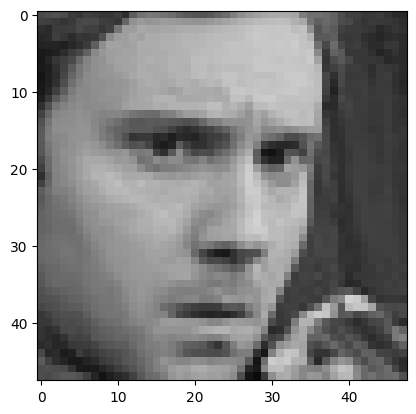

In [111]:
plt.imshow(img, cmap='gray', vmin=0, vmax=1)

In [112]:
class_info = sorted(
            [ d.name for d in os.scandir("D:/lab5dataset/Images/train") if d.is_dir()]
        )

class_info = dict(enumerate(class_info))

In [113]:
class_info

{0: 'Angry',
 1: 'Disgust',
 2: 'Fear',
 3: 'Happy',
 4: 'Neutral',
 5: 'Sad',
 6: 'Surprise'}

In [141]:
class_info[:]

KeyError: slice(None, None, None)

In [114]:
train_transform = transforms.Compose([
    transforms.ToPILImage(),                   
    transforms.Resize((48, 48)),              
    transforms.RandomHorizontalFlip(),         
    transforms.RandomRotation(20),             
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2), 
    transforms.ToTensor(),                     
    transforms.Normalize(mean=[0.5], std=[0.5]) 
])

val_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])


In [115]:
class myDataset(IterableDataset):
    def __init__(self, root_dir, shuffle=True, transform=None):
        super(myDataset).__init__()
        self.root_dir = root_dir
        self.shuffle = shuffle
        self.transform = transform
        self.classes = sorted(
            [d.name for d in os.scandir(root_dir) if d.is_dir()]
        )
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}

    def _get_file_paths(self):
        file_paths = []
        for cls in self.classes:
            cls_dir = os.path.join(self.root_dir, cls)
            if not os.path.isdir(cls_dir):
                continue
            for file in os.listdir(cls_dir):
                file_path = os.path.join(cls_dir, file)
                if os.path.isfile(file_path):
                    file_paths.append((file_path, cls))

        if self.shuffle:
            random.shuffle(file_paths)

        return file_paths

    def __iter__(self):
        file_paths = self._get_file_paths()
        worker_info = torch.utils.data.get_worker_info()

        if worker_info is None:
            iter_start = 0
            iter_end = len(file_paths)
        else:
            per_worker = int(math.ceil(len(file_paths) / float(worker_info.num_workers)))
            worker_id = worker_info.id
            iter_start = worker_id * per_worker
            iter_end = min(iter_start + per_worker, len(file_paths))

        for img_path, cls in file_paths[iter_start:iter_end]:
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = (img / 255).astype(np.float32)

            if self.transform:
                img = self.transform(img)

            label = self.class_to_idx[cls]
            yield img, label

In [116]:
class ImageModule (pl.LightningDataModule):
    def __init__(self, train_dir, val_dir, test_dir, batch_size, num_workers=8):
        super().__init__()
        self.train_dir = train_dir
        self.val_dir = val_dir
        self.test_dir = test_dir
        self.batch_size = batch_size
        self.num_workers = num_workers

    def setup(self, stage=None):
        self.train_dataset = myDataset(
            root_dir=self.train_dir,
            shuffle=True,
            transform=train_transform
        )

        self.val_dataset = myDataset(
            root_dir=self.val_dir,
            shuffle=True,
            transform=val_transform
        )

        self.test_dataset = myDataset(
            root_dir=self.test_dir,
            shuffle=False,
            transform=val_transform
        )

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            pin_memory=True,
            shuffle=False,
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            pin_memory=True,
            shuffle=False
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            pin_memory=True,
            shuffle=False
        )

In [117]:
dataset = myDataset("D:/lab5dataset/Images/train")


In [118]:
datas = next(iter(dataset))

In [119]:
datas

(array([[0.11372549, 0.10588235, 0.11372549, ..., 0.6901961 , 0.68235296,
         0.7176471 ],
        [0.08627451, 0.12156863, 0.10588235, ..., 0.6862745 , 0.6784314 ,
         0.7254902 ],
        [0.10588235, 0.11372549, 0.08627451, ..., 0.68235296, 0.6784314 ,
         0.72156864],
        ...,
        [0.5137255 , 0.48235294, 0.47058824, ..., 0.6862745 , 0.6784314 ,
         0.72156864],
        [0.5176471 , 0.50980395, 0.47058824, ..., 0.6862745 , 0.6784314 ,
         0.72156864],
        [0.5372549 , 0.49803922, 0.5019608 , ..., 0.6862745 , 0.6784314 ,
         0.72156864]], dtype=float32),
 5)

In [120]:
batch_size = 128

In [121]:
"""


(batch_size, 1, 48,48) -> по 32 ядрам - (batch_size, 32, 48,48)
maxPool c ядром 2 -> (batch_size, 32, 24,24)

дальше аналогично по 64 фичам

и по 128 фичам

итог - (batch_size, 128,6,6)

дальше flatten

классификация = кроссэнтрония


""";

In [ ]:
class SimpleCNN(pl.LightningModule):
    def __init__(self, num_classes=7, learning_rate=1e-3):
        super().__init__()
        self.save_hyperparameters()
        self.learning_rate = learning_rate





        self.conv_layers = nn.Sequential(

            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            

            nn.Conv2d(64, 128, kernel_size=5, padding=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(128 * 6 * 6, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )


        self.val_acc = Accuracy(task="multiclass", num_classes=7)
        self.train_acc = Accuracy(task='multiclass', num_classes=7)

        self.train_losses = []
        self.val_losses = []
        self.train_metrics = []
        self.val_metrics = []
        

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  
        x = self.fc_layers(x)
        return x

    def training_step(self, batch):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        acc = self.train_acc(logits, y)

        self.train_losses.append(loss.item())
        self.train_metrics.append(acc.item())

        self.log_dict({
            "training/loss": loss,
            "training/acc": acc
        })

        return loss

    def validation_step(self, batch):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        acc = self.val_acc(logits, y)

        self.val_losses.append(loss.item())
        self.val_metrics.append(acc.item())

        self.log_dict({
            "val/loss": loss,
            "val/acc": acc
        })

    def test_step(self, batch):
        x, y = batch
        logits = self(x)
        acc = self.test_acc(logits, y)
        self.log("test/acc", acc)
        return logits, y

    def on_train_epoch_end(self):
        avg_loss = sum(self.train_losses) / len(self.train_losses)
        avg_acc = sum(self.train_metrics) / len(self.train_metrics)


        print(f"Train epoch {self.current_epoch}. Avg Loss: {avg_loss:.4f}, Avg Acc: {avg_acc:.4f}")
        self.train_losses.clear()
        self.train_metrics.clear()


    def on_validation_epoch_end(self):
        avg_loss = sum(self.val_losses) / len(self.val_losses)
        avg_acc = sum(self.val_metrics) / len(self.val_metrics)



        print(f"Val epoch {self.current_epoch}. Avg Loss: {avg_loss:.4f}, Avg Acc: {avg_acc:.4f}")
        self.val_losses.clear()
        self.val_metrics.clear()




    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.learning_rate)


In [123]:
datamodule = ImageModule(
    train_dir="D:/lab5dataset/Images/train",
    val_dir="D:/lab5dataset/Images/validation",
    test_dir="D:/lab5dataset/Images/test",
    batch_size=128,
    num_workers=0
)

In [124]:
model = SimpleCNN()

In [125]:
logger = TensorBoardLogger("tensorboardlogs")

In [ ]:
early_stop_callback = EarlyStopping(
    monitor="val/loss",
    patience=5,  
    verbose=True,
    mode="min"
)

In [127]:
trainer = Trainer(
    max_epochs=201,
    logger=logger,
    accelerator='gpu' if torch.cuda.is_available() else 'cpu',
    log_every_n_steps=1,
    callbacks=[early_stop_callback]
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [128]:
trainer.fit(model, datamodule=datamodule)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type               | Params | Mode 
-----------------------------------------------------------
0 | augment     | Sequential         | 0      | train
1 | conv_layers | Sequential         | 224 K  | train
2 | fc_layers   | Sequential         | 2.4 M  | train
3 | val_acc     | MulticlassAccuracy | 0      | train
4 | train_acc   | MulticlassAccuracy | 0      | train
-----------------------------------------------------------
2.6 M     Trainable params
0         Non-trainable params
2.6 M     Total params
10.350    Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

C:\Users\Arseny\AppData\Roaming\Python\Python312\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Val epoch 0. Avg Loss: 1.9549, Avg Acc: 0.1523


C:\Users\Arseny\AppData\Roaming\Python\Python312\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss improved. New best score: 1.713


Val epoch 0. Avg Loss: 1.7118, Avg Acc: 0.3073
Train epoch 0. Avg Loss: 1.8593, Avg Acc: 0.2519


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss improved by 0.144 >= min_delta = 0.0. New best score: 1.569


Val epoch 1. Avg Loss: 1.5613, Avg Acc: 0.3773
Train epoch 1. Avg Loss: 1.6543, Avg Acc: 0.3382


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss improved by 0.045 >= min_delta = 0.0. New best score: 1.524


Val epoch 2. Avg Loss: 1.5185, Avg Acc: 0.4084
Train epoch 2. Avg Loss: 1.5452, Avg Acc: 0.3947


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss improved by 0.015 >= min_delta = 0.0. New best score: 1.509


Val epoch 3. Avg Loss: 1.4961, Avg Acc: 0.4399
Train epoch 3. Avg Loss: 1.4915, Avg Acc: 0.4195


Validation: |          | 0/? [00:00<?, ?it/s]

Val epoch 4. Avg Loss: 1.4926, Avg Acc: 0.4484
Train epoch 4. Avg Loss: 1.4500, Avg Acc: 0.4352


Validation: |          | 0/? [00:00<?, ?it/s]

Val epoch 5. Avg Loss: 1.5224, Avg Acc: 0.4517
Train epoch 5. Avg Loss: 1.4250, Avg Acc: 0.4472


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss improved by 0.030 >= min_delta = 0.0. New best score: 1.479


Val epoch 6. Avg Loss: 1.4604, Avg Acc: 0.4637
Train epoch 6. Avg Loss: 1.3956, Avg Acc: 0.4575


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss improved by 0.008 >= min_delta = 0.0. New best score: 1.471


Val epoch 7. Avg Loss: 1.4917, Avg Acc: 0.4440
Train epoch 7. Avg Loss: 1.3807, Avg Acc: 0.4650


Validation: |          | 0/? [00:00<?, ?it/s]

Val epoch 8. Avg Loss: 1.4793, Avg Acc: 0.4452
Train epoch 8. Avg Loss: 1.3625, Avg Acc: 0.4746


Validation: |          | 0/? [00:00<?, ?it/s]

Val epoch 9. Avg Loss: 1.4803, Avg Acc: 0.4827
Train epoch 9. Avg Loss: 1.3432, Avg Acc: 0.4815


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss improved by 0.038 >= min_delta = 0.0. New best score: 1.433


Val epoch 10. Avg Loss: 1.4101, Avg Acc: 0.4762
Train epoch 10. Avg Loss: 1.3210, Avg Acc: 0.4934


Validation: |          | 0/? [00:00<?, ?it/s]

Val epoch 11. Avg Loss: 1.4787, Avg Acc: 0.4896
Train epoch 11. Avg Loss: 1.3096, Avg Acc: 0.4929


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/loss improved by 0.021 >= min_delta = 0.0. New best score: 1.412


Val epoch 12. Avg Loss: 1.3920, Avg Acc: 0.4900
Train epoch 12. Avg Loss: 1.2926, Avg Acc: 0.5015


Validation: |          | 0/? [00:00<?, ?it/s]

Val epoch 13. Avg Loss: 1.4302, Avg Acc: 0.4947
Train epoch 13. Avg Loss: 1.2807, Avg Acc: 0.5108


Validation: |          | 0/? [00:00<?, ?it/s]

Val epoch 14. Avg Loss: 1.4736, Avg Acc: 0.4904
Train epoch 14. Avg Loss: 1.2693, Avg Acc: 0.5136


Validation: |          | 0/? [00:00<?, ?it/s]

Val epoch 15. Avg Loss: 1.5197, Avg Acc: 0.4979
Train epoch 15. Avg Loss: 1.2604, Avg Acc: 0.5142


Validation: |          | 0/? [00:00<?, ?it/s]

Val epoch 16. Avg Loss: 1.4546, Avg Acc: 0.5059
Train epoch 16. Avg Loss: 1.2554, Avg Acc: 0.5172


Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val/loss did not improve in the last 5 records. Best score: 1.412. Signaling Trainer to stop.


Val epoch 17. Avg Loss: 1.4476, Avg Acc: 0.4992
Train epoch 17. Avg Loss: 1.2429, Avg Acc: 0.5208


In [142]:
def plot_confusion_matrix(model, datamodule):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    preds = []
    targets = []

    test_loader = datamodule.test_dataloader()

    with torch.no_grad():
        for x, y in test_loader:
            x = x.cuda() if torch.cuda.is_available() else x
            y = y.cuda() if torch.cuda.is_available() else y
            logits = model(x)
            pred = torch.argmax(logits, dim=1)
            preds.append(pred.cpu().numpy())
            targets.append(y.cpu().numpy())

    preds = np.concatenate(preds)
    targets = np.concatenate(targets)

    cm = confusion_matrix(targets, preds)
    cm = confusion_matrix(targets, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(class_info.values()))
    disp.plot(cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()

In [143]:

def print_classification_report(model, datamodule, class_info):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    preds = []
    targets = []
    

    test_loader = datamodule.test_dataloader()

    with torch.no_grad():
        for x, y in test_loader:
            x = x.cuda() if torch.cuda.is_available() else x
            y = y.cuda() if torch.cuda.is_available() else y
            logits = model(x)
            pred = torch.argmax(logits, dim=1)
            preds.append(pred.cpu().numpy())
            targets.append(y.cpu().numpy())

    preds = np.concatenate(preds)
    targets = np.concatenate(targets)

    print(classification_report(targets, preds, target_names=list(class_info.values())))


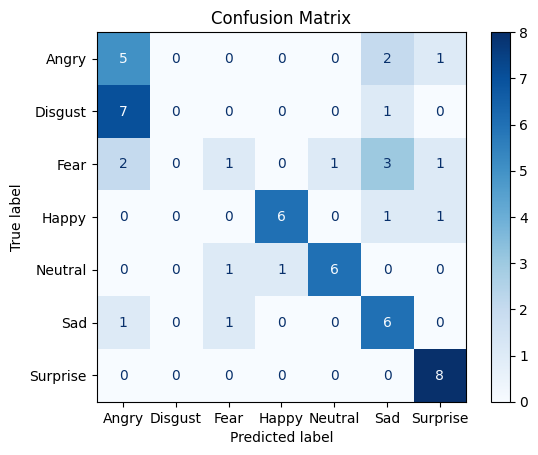

In [147]:
plot_confusion_matrix(model, datamodule)

In [ ]:
print_classification_report(model, datamodule, class_info)

              precision    recall  f1-score   support

       Angry       0.33      0.62      0.43         8
     Disgust       0.00      0.00      0.00         8
        Fear       0.33      0.12      0.18         8
       Happy       0.86      0.75      0.80         8
     Neutral       0.86      0.75      0.80         8
         Sad       0.46      0.75      0.57         8
    Surprise       0.73      1.00      0.84         8

    accuracy                           0.57        56
   macro avg       0.51      0.57      0.52        56
weighted avg       0.51      0.57      0.52        56



C:\Users\Arseny\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Arseny\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Arseny\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()